In [1]:
# limit memory used by gpu
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [2]:
import cv2
import os, glob
import numpy as np
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
#from tensorflow.keras.applications import  ResNet101
#from keras.utils.generic_utils import get_custom_objects
import skimage.morphology 
from skimage.morphology import disk
#from tensorflow.keras.models import load_model
#import lungs_finder as lf
#from tensorflow.keras import preprocessing
from tensorflow.keras import backend as K
#from tensorflow.keras import models
import tensorflow as tf
import numpy as np
import lungs_finder as lf




In [5]:
model_croping = tf.keras.models.load_model('H:/Projekty/Dane/COVID-19 Radiography Database/unet_lung_seg_serial.hdf5')
model = tf.keras.models.load_model('H:\Projekty\Dane\COVID-19 Radiography Database/resnet_variation.h5')
#model_croping = tf.keras.models.load_model('H:/Projekty/Dane/COVID-19 Radiography Database/unet_lung_seg_serial.hdf5')


In [10]:

#tf.keras.utils.plot_model(
#    model, to_file='model.png', show_shapes=False, show_layer_names=True,
#    rankdir='TB', expand_nested=False, dpi=96
#)

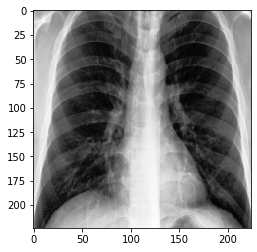

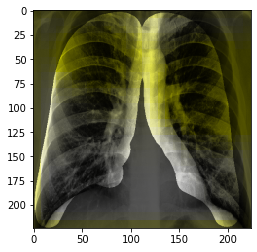

 The pattient has Covid_19 with probability of 99.40859079360962 %


In [11]:
#if image is not segmented
img_path = 'H:/Projekty/Dane/COVID-19 Radiography Database/not_cropped/train/class_a/COVID-19 (56).png'

#first cropp image 
img = cv2.imread(img_path) 


img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
image2 = cv2.equalizeHist(img_gray)
image = cv2.medianBlur(image2, 3)


scaled_image = image# cv2.resize(image, (1024,1024))
right_lung_hog_rectangle = lf.find_right_lung_hog(scaled_image)
left_lung_hog_rectangle = lf.find_left_lung_hog(scaled_image)
right_lung_lbp_rectangle = lf.find_right_lung_lbp(scaled_image)
left_lung_lbp_rectangle = lf.find_left_lung_lbp(scaled_image)
right_lung_haar_rectangle = lf.find_right_lung_haar(scaled_image)
left_lung_haar_rectangle = lf.find_left_lung_haar(scaled_image)
color_image = cv2.cvtColor(scaled_image, cv2.COLOR_GRAY2BGR)

if (right_lung_hog_rectangle is not None) and (left_lung_hog_rectangle is not None) :
    x1, y1, width1, height1 = right_lung_hog_rectangle
    x2, y2, width2, height2 = left_lung_hog_rectangle
    cimage1 = image2[np.minimum(y1, y2):np.maximum(y1+height1, y2+height2),x1:x2+width2] 
    pole1 = width1*height1+width2*height2

if (right_lung_lbp_rectangle is not None) and (left_lung_lbp_rectangle is not None):
    x1, y1, width1, height1 = right_lung_lbp_rectangle
    x2, y2, width2, height2 = left_lung_lbp_rectangle              
    cimage2 = image2[np.minimum(y1, y2):np.maximum(y1+height1, y2+height2),x1:x2+width2] 
    pole2 = width1*height1+width2*height2

if (right_lung_haar_rectangle is not None) and (left_lung_haar_rectangle is not None):
    x1, y1, width1, height1 = right_lung_haar_rectangle
    x2, y2, width2, height2 = left_lung_haar_rectangle
    cimage3 = image2[np.minimum(y1, y2):np.maximum(y1+height1, y2+height2),x1:x2+width2] 
    pole3 = width1*height1+width2*height2

if (pole1 >= pole2) and (pole1 >= pole3) and (pole1>0):
    cimage = cimage1
if (pole2 > pole1) and (pole2 >= pole3):
    cimage = cimage2
if (pole3 > pole1) and (pole3 > pole2):
    cimage = cimage3
if (cimage.shape[0]>0) and (cimage.shape[1]>0):
    image = cimage
    


image_c = img_gray
image_c = cv2.resize(image_c, (512,512), interpolation = cv2.INTER_AREA)
image_c = np.array(image_c) / 255
image_c = image_c.astype('float32')
image_to_predict = image_c.reshape(1, 512, 512,1)
predict_img = model_croping.predict(image_to_predict)
mask = predict_img[0,:,:,0]

mask[mask > 0.5] = 1
mask[mask <= 0.5] = 0.35

mask = cv2.medianBlur(mask, 3)
#mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_AREA)

#img = skimage.morphology.remove_small_objects(img,min_size=10000, connectivity=8)
mask = skimage.morphology.opening(mask,disk(10))
mask = skimage.morphology.dilation(mask, disk(20))
mask = cv2.resize(mask, (224,224), interpolation = cv2.INTER_AREA)


image_size = 224
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
#image = np.random.random((image_size, image_size, 3))
x_test = np.array(image) / 255
x_test = x_test.reshape(-1, image_size, image_size,3)
x_test = x_test.astype('float32')

dim = (image_size, image_size)
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)


img_tensor = x_test
layer = 'conv2d_5'
conv_layer = model.get_layer(layer)

heatmap_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(layer).output, model.output]
)

with tf.GradientTape() as tape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(predictions[0])]

grads = tape.gradient(loss, conv_output)
pooled_grads = K.mean(grads, axis=(0, 1, 2))

heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)

heatmap = np.maximum(heatmap, 0)
max_heat = np.max(heatmap)

if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
heatmap = heatmap[0,:,:]
heatmap = cv2.resize(heatmap, dim, interpolation = cv2.INTER_AREA)



#import seaborn as sns
#sns.set()
#ax = sns.heatmap(heatmap)
#plt.savefig('C:/Users/Adrian/Desktop/zdj/heatmap-02.png')


prediction = model.predict(x_test)
pred = np.argmax(prediction,axis=1)
probability = prediction.max()
result = 'unknown'
if pred[0] == 0:
    result = 'Covid_19'
if pred[0] == 1:
    result = 'Healthy Lungs!'
if pred[0] == 2:
    result = 'Pneumonia'
    
plt.imshow(image,cmap='gray')
plt.show()




result_image = image
result_image[:,:,2]=image[:,:,1]*heatmap 
result_image[:,:,0]=image[:,:,1]*heatmap 
result_image[:,:,0] = result_image[:,:,0]*mask
result_image[:,:,1] = result_image[:,:,1]*mask
result_image[:,:,2] = result_image[:,:,2]*mask

result_image2 = result_image
result_image2[:,:,2] = result_image[:,:,0]
result_image2[:,:,0] = result_image[:,:,1]

plt.imshow(result_image,cmap='gray')
plt.show()

print(f' The pattient has {result} with probability of {probability*100} %')
